# Considering Bias in Data


In [108]:
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Step 1: Getting the Article and Population Data

The first step is getting the data, which lives in several different places. You will need data that lists Wikipedia articles of politicians and data for country populations.<br />
The Wikipedia Category:Politicians by nationality was crawled to generate a list of Wikipedia article pages about politicians from a wide range of countries.<br />
The population data is drawn from the world population data sheet published by the Population Reference Bureau. This csv file had only two columns, Geography and Population. 


In [11]:
# Load Politicians by nationality data from the raw_files directory
politicians_by_country = pd.read_csv('../data/raw/politicians_by_country_SEPT.2022.csv')
politicians_by_country.head(2)

,name,url,country
0,Shahjahan Noori,https://en.wikipedia.org/wiki/Shahjahan_Noori,Afghanistan
1,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan


The population_by_country_2022.csv contains some rows that provide cumulative regional population counts. These rows are distinguished by having ALL CAPS values in the 'geography' field (e.g. AFRICA, OCEANIA). These rows won't match the country values in politicians_by_country.SEPT.2022.csv. For the sake of report coverage and analysis, I re-organized the data into four columns namely, continent, region, geography and population.


In [12]:
# Load reorganized country population data from the cleaned directory
population_by_country = pd.read_csv('../data/cleaned/population_by_country_2022_cleaned.csv')
population_by_country.head()

,continent,region,country,population
0,AFRICA,NORTHERN AFRICA,Algeria,44.9
1,AFRICA,NORTHERN AFRICA,Egypt,103.5
2,AFRICA,NORTHERN AFRICA,Libya,6.8
3,AFRICA,NORTHERN AFRICA,Morocco,36.7
4,AFRICA,NORTHERN AFRICA,Sudan,46.9


## Step 2: Getting Article Quality Predictions

In this step, I need to get the predicted quality scores for each article in the Wikipedia dataset using a machine learning system called ORES. This was originally an acronym for "Objective Revision Evaluation Service" but was simply renamed “ORES”. ORES is a machine learning tool that can provide estimates of Wikipedia article quality. The article quality estimates are, from best to worst:

- FA - Featured article
- GA - Good article
- B - B-class article
- C - C-class article
- Start - Start-class article
- Stub - Stub-class article 

<br/>
These were learned based on articles in Wikipedia that were peer-reviewed using the Wikipedia content assessment procedures. These quality classes are a sub-set of quality assessment categories developed by Wikipedia editors.<br/>
ORES requires a specific revision ID of a specific article to be able to make a label prediction. You can use the API:Info request to get a range of metadata on an article, including the most current revision ID of the article page.
<br/><br/>
The code below will try to get a Wikipedia page quality prediction from ORES for each politician’s article page by: 

- reading each line of politicians_by_country.SEPT.2022.csv, 
- making a page info request to get the current page revision, and 
- making an ORES request using the page title and current revision id.


In [13]:
# This code will access page info data using the 
# [MediaWiki REST API for the EN Wikipedia](https://www.mediawiki.org/wiki/API:Main_page).
#########
#
#    CONSTANTS
#

# The basic English Wikipedia API endpoint
API_ENWIKIPEDIA_ENDPOINT = "https://en.wikipedia.org/w/api.php"

# We'll assume that there needs to be some throttling for these requests - we should always be nice to a free data resource
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<harrymn@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is a string of additional page properties that can be returned see the Info documentation for
# what can be included. If you don't want any this can simply be the empty string
PAGEINFO_EXTENDED_PROPERTIES = "talkid|url|watched|watchers"
#PAGEINFO_EXTENDED_PROPERTIES = ""

# This template lists the basic parameters for making this
PAGEINFO_PARAMS_TEMPLATE = {
    "action": "query",
    "format": "json",
    "titles": "",           # to simplify this should be a single page title at a time
    "prop": "info",
    "inprop": PAGEINFO_EXTENDED_PROPERTIES
}

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [14]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageinfo_per_article(article_title = None, 
                                 endpoint_url = API_ENWIKIPEDIA_ENDPOINT, 
                                 request_template = PAGEINFO_PARAMS_TEMPLATE,
                                 headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    request_template['titles'] = article_title
        
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or any other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(endpoint_url, headers=headers, params=request_template)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


This functions below generate quality scores for article revisions using [ORES](https://www.mediawiki.org/wiki/ORES).The API documentation can be access from the main [ORES](https://ores.wikimedia.org) page. 

In [15]:
#########
#
#    CONSTANTS
#

# The current ORES API endpoint
API_ORES_SCORE_ENDPOINT = "https://ores.wikimedia.org/v3"
# A template for mapping to the URL
API_ORES_SCORE_PARAMS = "/scores/{context}/{revid}/{model}"

# Use some delays so that we do not hammer the API with our requests
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<harrymn@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022'
}

# A dictionary of English Wikipedia article titles (keys) and sample revision IDs that can be used for this ORES scoring example
ARTICLE_REVISIONS = { 'Bison':1085687913 , 'Northern flicker':1086582504 , 'Red squirrel':1083787665 , 'Chinook salmon':1085406228 , 'Horseshoe bat':1060601936 }

# This template lists the basic parameters for making an ORES request
ORES_PARAMS_TEMPLATE = {
    "context": "enwiki",        # which WMF project for the specified revid
    "revid" : "",               # the revision to be scored - this will probably change each call
    "model": "articlequality"   # the AI/ML scoring model to apply to the reviewion
}
#
# The current ML models for English wikipedia are:
#   "articlequality"
#   "articletopic"
#   "damaging"
#   "version"
#   "draftquality"
#   "drafttopic"
#   "goodfaith"
#   "wp10"
#
# The specific documentation on these is scattered so if you want to use one you'll have to look around.
#

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article revisions. Therefore, the main parameter is article_revid.

In [16]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_ores_score_per_article(article_revid = None, 
                                   endpoint_url = API_ORES_SCORE_ENDPOINT, 
                                   endpoint_params = API_ORES_SCORE_PARAMS, 
                                   request_template = ORES_PARAMS_TEMPLATE,
                                   headers = REQUEST_HEADERS,
                                   features=False):
    # Make sure we have an article revision id
    if not article_revid: return None
    
    # set the revision id into the template
    request_template['revid'] = article_revid
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # the features used by the ML model can sometimes be returned as well as scores
    if features:
        request_url = request_url+"?features=true"
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like ORES - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


This process will loop through all articles (politicians by country) and try to retreive their revision counts. If an article is found without a revision, it is saved inside a list called ARTICLE_NO_REVISION. All articles with revisions are saved inside a dictionary with the name ARTICLE_REVISIONS

In [17]:
# A function to dump json response
def outputToJson(filename,data):
    out_path = filename + '.json'
    with open(out_path, 'w') as f:
        json.dump(data, f)

In [8]:
ARTICLE_NO_REVISION = []
ARTICLE_REVISIONS = {}

ARTICLE_TITLES = politicians_by_country['name']

for i in range(0, len(ARTICLE_TITLES)):
    info = request_pageinfo_per_article(ARTICLE_TITLES[i])
    obj = info['query']['pages']
    info_key = list(obj.keys())[0]
    revision_id = 0
    if 'lastrevid' in info['query']['pages'][info_key]:
        revision_id = info['query']['pages'][info_key]['lastrevid']
    # Check if article as a revision
    if revision_id and revision_id>0:
        # Update ARTICLE_REVISIONS dict with the article and last revision number
        ARTICLE_REVISIONS.update({ARTICLE_TITLES[i]:revision_id})
    else:
        # update the list of articles with no revision
        ARTICLE_NO_REVISION.append(ARTICLE_TITLES[i])
    print("Processed article:", ARTICLE_TITLES[i], revision_id)
outputToJson("../data/output/article_revisions", ARTICLE_REVISIONS)
print('Completed')

Processed article: Suleiman Mohamoud Adan 1100648418
Processed article: Zamzam Abdi Adan 1104180941
Processed article: Ahmed Aw Dahir 1062918876
Processed article: Mohammed Ahmed Alin 1067230288
Processed article: Mohamed Nour Arrale 1010517655
Processed article: Abdirizak Ibrahim Mohamed Attash 1106387976
Processed article: Abdirahman Aw Ali Farrah 1090813639
Processed article: Bashe Awil Omar 1080305059
Processed article: Buurmadow 1060454282
Processed article: Mohamed Abdi Dhinbil 1105389938
Processed article: Hussein Ali Duale 1061678975
Processed article: Hussein Abdi Dualeh 1046373247
Processed article: Bashe Mohamed Farah 1100193203
Processed article: Khadra Haji Ismail Geid 1110909858
Processed article: Dayib Gurey 1105996972
Processed article: Suleiman Hassan Haddi 1080321751
Processed article: Suleiman Haglotosiye 1113248839
Processed article: Hassan Ismail Yusuf 1095741540
Processed article: Abdiaziz Hussein Hassan 1050666572
Processed article: Hussein Mohamed Mohamoud 10252

Processed article: Clement Wani Konga 1102830572
Processed article: Baba Medan Konya 919549108
Processed article: Kuol Deim Kuol 1006056090
Processed article: Samson L. Kwaje 1055834802
Processed article: Felix Ladu 1091814441
Processed article: Paterno Legge 1075466143
Processed article: Stephen Lemi Lokuron 1075465380
Processed article: Natisio Loluke 919628419
Processed article: Joseph Lual Acuil 1063289231
Processed article: Vincent Kujo Lubong 1069101167
Processed article: Mabior Garang De-Mabior 1113657913
Processed article: Mary Karlino Madut 1094131882
Processed article: Simon Mijok Majak 1100729735
Processed article: Madang Majok 930031820
Processed article: Abraham Gum Makuach 1112713366
Processed article: Juma Ali Malou 919560655
Processed article: Mary Mawai 1105243093
Processed article: James Ajongo Mawut 1093453653
Processed article: Peter Mayen 1109187939
Processed article: Juliet Raphael Michael 1094131128
Processed article: John Peter Miskin 1091499255
Processed articl

Processed article: Gustaf af Wetterstedt 1033191860
Processed article: Bertil Zachrisson 1081155174
Processed article: Céline Amaudruz 1078966867
Processed article: Beat Arnold 1103551315
Processed article: Mustafa Atici 1093168910
Processed article: Gallus Jacob Baumgartner 1034339108
Processed article: Martin Bäumle 1113180976
Processed article: Pierre François Bellot 1085380321
Processed article: Jacqueline Berenstein-Wavre 1098279107
Processed article: Peter Bodenmann 1097652987
Processed article: Ulrich Bremi 1109100989
Processed article: Achille Casanova 1109101260
Processed article: Conradin Cramer 1109136165
Processed article: Niklaus Dachselhofer 989253083
Processed article: Sigmund von Erlach 1047996896
Processed article: Heinrich Escher 1051201875
Processed article: Johann Rudolf Faesch 1109260563
Processed article: Peter Falck 1113518708
Processed article: Franz Rudolf Frisching 1025992173
Processed article: Urs Glutz von Blotzheim 1079107579
Processed article: Jürg Grossen

Processed article: Yat Hwaidi 1081234427
Processed article: Aliança de Araújo 1059363091
Processed article: Manuel Carrascalão 1071880738
Processed article: María do Céu 1112159193
Processed article: Brigida Antónia Correia 1059174694
Processed article: Isabel da Costa Ferreira 1112773533
Processed article: Albina Marçal Freitas 1112274488
Processed article: Ángela Freitas 1085081003
Processed article: Justino Mota 1099899758
Processed article: Maria da Paixão da Costa 1076208477
Processed article: Olinda Morais 1009671491
Processed article: Manuel Magalhaes de Oliveira 982569489
Processed article: Alfredo Pires 1082511668
Processed article: Nino Konis Santana 1080700969
Processed article: José Abílio Osório Soares 1112065021
Processed article: João da Costa Tavares 1095266698
Processed article: Mário Viegas Carrascalão 1072430980
Processed article: Maria Terezinha Viegas 1112159660
Processed article: Kafui Adjamagbo-Johnson 1090161620
Processed article: Angèle Dola Akofa Aguigah 10991

Processed article: Telavi Ministry 1110459962
Processed article: Fiatau Penitala Teo 1069888129
Processed article: Solofa Uota 994787433
Processed article: Ssendi Mosh Afrikan 1115116952
Processed article: Apollo Ofwono 1099627033
Processed article: Christine Apolot 1079944698
Processed article: Florence Akiiki Asiimwe 1027457516
Processed article: Charles Ayume 1086952268
Processed article: Edith Mary Bataringaya 1095198944
Processed article: Flavia Rwabuhoro Kabahenda 1081460224
Processed article: John Kabaireho 944462983
Processed article: Joseph Kabuleta 1112443092
Processed article: Apollo Kaggwa 1074999358
Processed article: Michael Kawalya Kagwa 943104033
Processed article: Robert Mugabe Kakyebezi 1055443363
Processed article: Paulo Kavuma 1079821209
Processed article: Patrick Kayemba 1036632663
Processed article: Daniel Kidega 1110604657
Processed article: Yabezi Kiiza 994379167
Processed article: Pumla Kisosonkole 1092915114
Processed article: Annie Logiel 1078602113
Processed

Processed article: Mohammed Lutf al-Iryani 902034742
Processed article: Abd Al-Rahman Ali Al-Jifri 1070785465
Processed article: Tawakkol Karman 1114996123
Processed article: Hussein Khairan 1107464188
Processed article: Hasan al-Lawzi 1110174341
Processed article: Ahmed al-Maisari 1114348953
Processed article: Mohammed Ali Al-Maqdashi 1115113088
Processed article: Hooria Mashhour 1110863738
Processed article: Huria Mashoor 1111069538
Processed article: Mutaher al-Masri 1109834972
Processed article: Ahmad Awad bin Mubarak 1114134493
Processed article: Muhammad bin Yahya bin Muhammad 1086283208
Processed article: Ali Muhammad Mujawar 1106369055
Processed article: Nasr Taha Mustafa 1110709467
Processed article: Abdul Qader Qahtan 1110319682
Processed article: Mohamed Saleh Qara'a 1074122152
Processed article: Mohamed Qubaty 1113837714
Processed article: Rashad al-Alimi 1114504154
Processed article: Abdulwahab al-Rawhani 1106993078
Processed article: Mohammed al-Sabry 949762548
Processed 

NameError: name 'outputToJson' is not defined

In [18]:
def read_json(filename):
    data = {}
    with open(filename, "r") as f:
        data = json.loads(f.read())
    
    return data

In [272]:
ARTICLE_REVISIONS = read_json("../data/output/article_revisions.json")
ARTICLE_QUALITY = {}
for ARTICLE in ARTICLE_REVISIONS:
    score = request_ores_score_per_article(ARTICLE_REVISIONS[ARTICLE])
    obj = score['enwiki']['scores']
    info_key = list(obj.keys())[0]
    quality = score['enwiki']['scores'][info_key]['articlequality']['score']['prediction']
    ARTICLE_QUALITY.update({ARTICLE:quality})
    print("Processed article:", ARTICLE, "rating:", quality)
outputToJson("../data/output/article_quality", ARTICLE_QUALITY)
print('Completed')

Processed article: Shahjahan Noori rating: GA
Processed article: Abdul Ghafar Lakanwal rating: Start
Processed article: Majah Ha Adrif rating: Start
Processed article: Haroon al-Afghani rating: B
Processed article: Tayyab Agha rating: Start
Processed article: Ahmadullah Wasiq rating: Start
Processed article: Aziza Ahmadyar rating: Start
Processed article: Muqadasa Ahmadzai rating: Start
Processed article: Mohammad Sarwar Ahmedzai rating: Start
Processed article: Amir Muhammad Akhundzada rating: Start
Processed article: Nasrullah Baryalai Arsalai rating: Start
Processed article: Mohammad Asim Asim rating: Stub
Processed article: Atiqullah Atifmal rating: Start
Processed article: Abdul Rahim Ayoubi rating: Start
Processed article: Alhaj Mutalib Baig rating: Start
Processed article: Ismael Balkhi rating: Start
Processed article: Abdul Baqi Turkistani rating: Stub
Processed article: Mohammad Ghous Bashiri rating: Start
Processed article: Abas Basir rating: C
Processed article: Jan Baz rati

Processed article: Xhavid Leskoviku rating: Start
Processed article: Sabit Lulo rating: Stub
Processed article: Gjon Markagjoni rating: C
Processed article: Tefik Mborja rating: Start
Processed article: Fatmir Mediu rating: Stub
Processed article: Hysni Milloshi rating: Start
Processed article: Musa Qazimi rating: GA
Processed article: Mustafa Ndroqi rating: Stub
Processed article: Behxhet Nepravishta rating: Stub
Processed article: Adrian Neritani rating: Start
Processed article: Sali Nivica rating: Start
Processed article: Thoma Orologa rating: Start
Processed article: Bedri Pejani rating: C
Processed article: Pertef Pogoni rating: Stub
Processed article: Kadri Prishtina rating: Start
Processed article: Ymer Prizreni rating: Start
Processed article: Avni Rustemi rating: C
Processed article: Chatin Sarachi rating: C
Processed article: Nebi Sefa rating: Stub
Processed article: Eduard Shalsi rating: Start
Processed article: Ylli Vesel Shehu rating: Stub
Processed article: Athanas Shundi

Processed article: Ricardo Kennedy rating: Stub
Processed article: Carlos Kunkel rating: Stub
Processed article: Norberto La Porta rating: Stub
Processed article: Andrés Larroque rating: Start
Processed article: Julián de Leyva rating: Stub
Processed article: Mónica López (politician) rating: Stub
Processed article: Lucio Victorio Mansilla rating: Start
Processed article: Nicolás Massot rating: Start
Processed article: Juan Mignaburu rating: Stub
Processed article: Guillermo Montenegro rating: Stub
Processed article: Mariano Moreno rating: B
Processed article: Marcelo Muniagurria rating: Stub
Processed article: Fernando Nadra rating: C
Processed article: Rómulo Sebastián Naón rating: Start
Processed article: Santiago G. O'Farrell rating: Start
Processed article: Miguel Ángel Pesce rating: Start
Processed article: Carlos Petroni rating: C
Processed article: Alejo Peyret rating: B
Processed article: Aldo Pignanelli rating: Stub
Processed article: Enrique S. Quintana rating: Start
Process

Processed article: Fuad Alasgarov rating: C
Processed article: Anvar Alikhanov rating: Stub
Processed article: Tarlan Aliyarbayov rating: GA
Processed article: Dilara Aliyeva rating: Start
Processed article: Ali Asadov rating: Start
Processed article: Akram Aylisli rating: C
Processed article: Sahil Babayev rating: Start
Processed article: Huseyngulu Baghirov rating: Start
Processed article: Alovsat Bakhshiyev rating: Start
Processed article: Rafael Kamil Dzhabrailov rating: Stub
Processed article: Matin Eynullayev rating: Start
Processed article: Vilayat Eyvazov rating: Start
Processed article: Abdurrahman Fatalibeyli rating: C
Processed article: Fazail Ibrahimli rating: Stub
Processed article: Solomon Grobshtein rating: Stub
Processed article: Teymur Guliyev rating: Stub
Processed article: Mammad Gurbanov rating: Start
Processed article: Asaf Hajiyev rating: C
Processed article: Farhad Hajiyev rating: Start
Processed article: Jamil Hasanli rating: C
Processed article: Ali M. Hasanov 

Processed article: Davidson Ishmael rating: Stub
Processed article: Colin Everett Jordan rating: Stub
Processed article: John Andrew King rating: Start
Processed article: Shantal Munro-Knight rating: Stub
Processed article: Glyne Murray rating: Stub
Processed article: Harry Scott Newlands rating: Stub
Processed article: Charles Duncan O'Neal rating: Start
Processed article: Samuel Jackman Prescod rating: C
Processed article: Shanika Roberts-Odle rating: Stub
Processed article: Ryan Straughan rating: Stub
Processed article: Dwight Sutherland rating: Stub
Processed article: Kerrie Symmonds rating: Start
Processed article: Yury Ambrazevich rating: Stub
Processed article: Lyavon Barshchewski rating: Stub
Processed article: Siarhei Cherachen rating: Start
Processed article: Zmitser Dashkevich rating: Start
Processed article: Siamion Domash rating: Stub
Processed article: Tsimafei Dranchuk rating: Start
Processed article: Alaksandar Dubko rating: Stub
Processed article: Alana Gebremariam rat

Processed article: Jigme Wangchuk rating: Stub
Processed article: Lhatu Wangchuk rating: Stub
Processed article: Khandu Wangchuk rating: Start
Processed article: Norbu Wangchuk rating: Stub
Processed article: Tshering Wangchuk rating: Start
Processed article: Karma Donnen Wangdi rating: Start
Processed article: Tshencho Wangdi rating: Start
Processed article: Ugyen Wangdi rating: Stub
Processed article: Dechen Wangmo (politician) rating: Start
Processed article: Dechen Zangmo rating: Stub
Processed article: Neten Zangmo rating: Start
Processed article: Nidup Zangpo rating: Stub
Processed article: Yeshey Zimba rating: Start
Processed article: Nataniel Aguirre rating: C
Processed article: Jacobo Aillón rating: Start
Processed article: Isaac Ávalos rating: Stub
Processed article: Augusto Céspedes rating: Start
Processed article: Soledad Chapetón rating: Start
Processed article: Adolfo Chávez rating: Stub
Processed article: Chi Hyun Chung rating: C
Processed article: Daniel Sánchez Bustama

Processed article: Francisco José Pinheiro rating: Start
Processed article: Mario Pinotti rating: C
Processed article: Henrique Pizzolato rating: Start
Processed article: Plínio de Arruda Sampaio Jr. rating: C
Processed article: Irondi Pugliesi rating: Stub
Processed article: Eusébio de Queirós rating: C
Processed article: Ratinho (TV presenter) rating: Start
Processed article: Marco Antonio Raupp rating: Start
Processed article: Robert Rey (plastic surgeon) rating: C
Processed article: Ary Rigo rating: Stub
Processed article: Antônio Ricardo dos Santos rating: Start
Processed article: Euclides Scalco rating: Stub
Processed article: Aldo Schneider rating: Stub
Processed article: Augusto Severo de Albuquerque Maranhão rating: Stub
Processed article: José Manuel da Silva, Baron of Tietê rating: Stub
Processed article: Fabiano Silveira rating: Start
Processed article: Jose de Sousa Campos rating: Stub
Processed article: Irineu Evangelista de Sousa, Viscount of Mauá rating: C
Processed art

Processed article: Dorothy L. Njeuma rating: Start
Processed article: Bernard Njonga rating: Stub
Processed article: Arouna N'Joya rating: Stub
Processed article: Edouard Nomo-Ongolo rating: Stub
Processed article: Antoine Ntsimi rating: C
Processed article: André Ngongang Ouandji rating: Stub
Processed article: Paul Pondi rating: C
Processed article: Félix Sabal Lecco (politician) rating: C
Processed article: François Sengat-Kuo rating: Stub
Processed article: Félix Tonye Mbog rating: Start
Processed article: Kah Walla rating: GA
Processed article: José Manuel Gomes Andrade rating: Stub
Processed article: Honório Barreto rating: Start
Processed article: Fernando Elísio Freire rating: Start
Processed article: Pedro Fernandes Lopes rating: C
Processed article: Paulo Rocha (Cape Verde politician) rating: Stub
Processed article: Arlindo do Rosário rating: Stub
Processed article: Gilberto Correia Carvalho Silva rating: Stub
Processed article: Luís Filipe Tavares rating: Start
Processed art

Processed article: José Eusebio Caro rating: Stub
Processed article: Iván Cepeda rating: Start
Processed article: Vicky Colbert rating: Start
Processed article: Alfredo Cuello Baute rating: Start
Processed article: Alfonso Dávila Ortiz rating: C
Processed article: Luis Eduardo Díaz Granados rating: Stub
Processed article: Olga Duque de Ospina rating: Stub
Processed article: Eduardo Enríquez Maya rating: Stub
Processed article: Miguel Amín Escaf rating: Stub
Processed article: Juan Carlos Esguerra Portocarrero rating: Stub
Processed article: Juan García del Río rating: Stub
Processed article: Daniel García-Peña rating: Start
Processed article: Enrique Gil Botero rating: GA
Processed article: Guillermo González (politician) rating: Stub
Processed article: Bernardo Guerra Serna rating: Stub
Processed article: Carlos Mauro Hoyos rating: C
Processed article: Augusto Ibáñez Guzmán rating: Start
Processed article: Gilma Jiménez rating: Stub
Processed article: Roberto Junguito rating: Stub
Pro

Processed article: Tranquilino de Bonilla y Herdocia rating: Stub
Processed article: Juan José de Bonilla y Herdocia rating: Stub
Processed article: Miguel de Bonilla y Laya-Bolívar rating: Start
Processed article: Stephan Brunner rating: Stub
Processed article: Florencio del Castillo rating: Start
Processed article: Paola Vega Castillo rating: Stub
Processed article: Ramón Castro y Ramírez rating: Stub
Processed article: Ricardo Castro Beeche rating: Stub
Processed article: Teodoro Willink Castro rating: Stub
Processed article: José Joaquín Chaverri Sievert rating: Stub
Processed article: José Miguel Corrales Bolaños rating: Stub
Processed article: Correque rating: Start
Processed article: Aquileo J. Echeverría rating: Start
Processed article: El Guarco rating: Start
Processed article: Narciso Esquivel y Salazar rating: Stub
Processed article: Alberto Fait Lizano rating: Stub
Processed article: Gerardo Gómez Ramírez rating: Stub
Processed article: Joaquín Gutiérrez rating: C
Processed

Processed article: Laureano de Torres y Ayala rating: C
Processed article: Salvador Valdés Mesa rating: Start
Processed article: Nikos Christodoulides rating: C
Processed article: Ioannis Clerides rating: Start
Processed article: Takis Evdokas rating: Stub
Processed article: Oz Karahan rating: Stub
Processed article: Andreas Koukouma rating: C
Processed article: Pantelis Kouros rating: Stub
Processed article: Kyrillos III of Cyprus rating: Stub
Processed article: Michalis Paraskevas rating: C
Processed article: Christos Patsalides rating: Stub
Processed article: Nicos A. Rolandis rating: Start
Processed article: Benon Sevan rating: Start
Processed article: Stefanos Stefanou (politician) rating: Start
Processed article: Michael Zampelas rating: Start
Processed article: Josef Barák rating: Stub
Processed article: Dagmar Burešová rating: C
Processed article: František Ringo Čech rating: C
Processed article: Jaroslav Chalupský rating: Stub
Processed article: Petr Cibulka rating: Start
Proc

Processed article: Doris Soliz rating: Start
Processed article: Jhajaira Urresta rating: Start
Processed article: Marllely Vásconez rating: Stub
Processed article: Alfredo Vera Vera rating: Stub
Processed article: Nathalie Viteri rating: Start
Processed article: Mohsen Badawi rating: Start
Processed article: Abdelfattah al-Banna rating: Stub
Processed article: Joseph Cattaui rating: Start
Processed article: Khaled Dawoud rating: Stub
Processed article: Ibrahim El-Gohary rating: Start
Processed article: Rafik Habib rating: Start
Processed article: Mohamed Ismail rating: C
Processed article: Mahmoud Ahmad Ibiary rating: Start
Processed article: Mona Makram-Ebeid rating: Stub
Processed article: Ahmad Mazlum rating: Start
Processed article: George Messiha rating: Stub
Processed article: Mostafa Alnagar rating: C
Processed article: Diaa Rashwan rating: Start
Processed article: Talaat Sadat rating: Start
Processed article: Miguel Álvarez Castro rating: Stub
Processed article: Mario Antonio A

Processed article: Reino Ragnar Lehto rating: Stub
Processed article: Keijo Liinamaa rating: Start
Processed article: Verner Lindberg rating: Stub
Processed article: Olavi Mäenpää rating: Start
Processed article: Nils Mustelin rating: Start
Processed article: Kirsi Piha rating: Stub
Processed article: Toivo Topias Pohjala rating: Stub
Processed article: Karl August Ramsay rating: Stub
Processed article: Elisabeth Rehn rating: C
Processed article: Eino S. Repo rating: Start
Processed article: Matti Saarinen rating: Stub
Processed article: Helvi Sipilä rating: Start
Processed article: Georg Magnus Sprengtporten rating: Start
Processed article: Jacob Magnus Sprengtporten rating: C
Processed article: Aleksander Strandman rating: Stub
Processed article: Christoffer Taxell rating: Start
Processed article: Heikki Heikinpoika Vaanila rating: Stub
Processed article: Jaana Vasama rating: Stub
Processed article: Miranda Vuolasranta rating: Start
Processed article: Nils Westermarck rating: Stub
Pr

Processed article: Édouard Jonas rating: C
Processed article: Jean Kaltenbach rating: Stub
Processed article: Philippe Karsenty rating: C
Processed article: Pierre-Charles Krieg rating: Start
Processed article: Étienne de La Grange rating: Stub
Processed article: François-René de La Tour du Pin Chambly, marquis de La Charce rating: C
Processed article: Guillaume-Xavier Labbey de Pompières rating: GA
Processed article: Joachim Labrouche rating: Stub
Processed article: Suzanne Lacore rating: C
Processed article: Jean-Baptiste Lacoste rating: Start
Processed article: Chrétien François de Lamoignon de Basville rating: Stub
Processed article: Antoine-Adrien Lamourette rating: Start
Processed article: Hyacinthe Gaëtan de Lannion rating: Stub
Processed article: Louis Lareng rating: Stub
Processed article: Hippolyte Laroche rating: Start
Processed article: Marc David Alba Lasource rating: Start
Processed article: Lucien Le Foyer rating: C
Processed article: Jean Le Mercier rating: Start
Proces

Processed article: Shqiprim Arifi rating: Start
Processed article: Rudi Arndt rating: Start
Processed article: Rudolf Bahro rating: C
Processed article: Otto Ballerstedt rating: C
Processed article: Joachim Otto von Bassewitz rating: Start
Processed article: Bruno Baum rating: C
Processed article: Karl Theodor Bayrhoffer rating: C
Processed article: Otto Beck rating: Start
Processed article: Klaus Bernbacher rating: C
Processed article: Gerhard Besier rating: C
Processed article: Georg von Blumenthal rating: Start
Processed article: Johann Christian von Boyneburg rating: Stub
Processed article: Kristin Brinker rating: Stub
Processed article: Rudolf Brinkmann (economist) rating: Start
Processed article: Wolfram Brück rating: Start
Processed article: Heinrich von Brühl rating: C
Processed article: Ignatz Bubis rating: C
Processed article: Stephan von Dassel rating: Stub
Processed article: Karamba Diaby rating: C
Processed article: John Ehret rating: Start
Processed article: Karl Eichfeld

Processed article: John Hope Smith rating: Start
Processed article: Sulemanu Kwame Tandoh rating: Start
Processed article: John van der Puije rating: C
Processed article: Victoria Tagoe rating: Stub
Processed article: Nana Oye Mansa Yeboaa rating: Start
Processed article: Sefis Anastasakos rating: Stub
Processed article: Avraam Vaporidis rating: Stub
Processed article: Christos Daralexis rating: Stub
Processed article: Alcibiades Diamandi rating: C
Processed article: Ali Dino rating: Stub
Processed article: Georgios Drys rating: Stub
Processed article: Asimakis Fotilas rating: Start
Processed article: Spyridon Galinos rating: Stub
Processed article: Nasos Iliopoulos rating: Start
Processed article: Ioannis Malachias rating: Stub
Processed article: Theophilos Kamberidis rating: C
Processed article: Stavros Karampelas rating: Stub
Processed article: Ioanna Karyofylli rating: Start
Processed article: Giorgos Katiforis rating: Stub
Processed article: Yannis Katsafados rating: Stub
Processe

Processed article: Roy Fredericks rating: Start
Processed article: Rahman Baccus Gajraj rating: Stub
Processed article: Winifred Gaskin rating: C
Processed article: Joseph Harmon rating: Stub
Processed article: Rashleigh Jackson rating: Stub
Processed article: Manzoor Nadir rating: Start
Processed article: Ubraj Narine rating: Stub
Processed article: Robert Persaud rating: Stub
Processed article: Jane Phillips-Gay rating: C
Processed article: Barton Scotland rating: Stub
Processed article: C. N. Sharma rating: Start
Processed article: Alfred A. Thorne rating: B
Processed article: A. R. F. Webber rating: Start
Processed article: Robert Victor Evan Wong rating: C
Processed article: President of Haiti rating: C
Processed article: Georges Anglade rating: Start
Processed article: Paul Arcelin rating: Start
Processed article: Rosalvo Bobo rating: Start
Processed article: Jean-Fernand Brierre rating: Start
Processed article: Luckner Cambronne rating: Start
Processed article: Massillon Coicou 

Processed article: Réka Szemerkényi rating: Stub
Processed article: Lajos Szikszai rating: Start
Processed article: Pál Szinyei Merse rating: Start
Processed article: Géza Szőcs rating: Start
Processed article: Béla Szombati rating: Start
Processed article: Tamás Herczeg rating: Stub
Processed article: Pál Tar rating: Stub
Processed article: László Teleki rating: Start
Processed article: Kálmán Thaly rating: Start
Processed article: György Thurzó rating: Start
Processed article: Tibor Farkas rating: C
Processed article: Tibor Nunkovics rating: Stub
Processed article: Bence Tordai rating: C
Processed article: Klára Ungár rating: Stub
Processed article: Vilmos Vályi-Nagy rating: C
Processed article: Géza Varga (politician) rating: Stub
Processed article: András Várhelyi rating: Stub
Processed article: Miklós Vásárhelyi rating: Start
Processed article: Gusztáv Vizsolyi rating: Stub
Processed article: Béla Vörösmarty rating: Stub
Processed article: Miklós Wesselényi rating: C
Processed art

Processed article: Kanwar Sandhu rating: Start
Processed article: Sangat Singh Gilzian rating: Stub
Processed article: Hari Ram Sardar rating: Stub
Processed article: Sanjib Sardar rating: Stub
Processed article: Sarju Prasad Misra rating: Stub
Processed article: Chandana Sarkar rating: Stub
Processed article: C. H. Sekar rating: Stub
Processed article: G. Sendhil Kumar rating: Stub
Processed article: Seth Kishan Dass rating: Start
Processed article: Nirav Shah (politician) rating: Start
Processed article: Gyanesh Sharma rating: Stub
Processed article: Radha Mohan Sharma rating: Start
Processed article: Gopal Singh Shekhawat rating: Start
Processed article: Sunil Shelke rating: Stub
Processed article: Tukaram Shrangare rating: C
Processed article: Zeeshan Siddique rating: Start
Processed article: Abbas Siddiqui rating: Start
Processed article: Onkar Singh Lakhawat rating: C
Processed article: Binod Kumar Singh rating: Stub
Processed article: Master Gurbanta Singh rating: C
Processed ar

Processed article: Farhad Dejpasand rating: Stub
Processed article: Nasr al-Din (Yunnan) rating: C
Processed article: Esfandiar Ekhtiyari rating: GA
Processed article: Naeimeh Eshraghi rating: Start
Processed article: Roozbeh Farahanipour rating: Start
Processed article: Sohrab Gilani rating: Start
Processed article: Fereidon Hasanvand rating: Stub
Processed article: Seyed Zia Hashemi rating: Stub
Processed article: Heshmatollah Falahatpishe rating: Start
Processed article: Heydar Latifiyan rating: GA
Processed article: Amir Hossein Jahanshahi rating: C
Processed article: Jalal ed-Din Amir Chakhmaq Shami rating: Stub
Processed article: Yadollah Javani rating: Start
Processed article: Roohallah Jomei rating: C
Processed article: Hamid Kahram rating: Stub
Processed article: Mohammad Reza Kalaei rating: C
Processed article: Mohammad Khamenei rating: C
Processed article: Kazem Khavazi rating: Stub
Processed article: Ensieh Khazali rating: Stub
Processed article: Mehrdad Khonsari rating: C


Processed article: Awni Yusuf rating: Stub
Processed article: Yusuf Salman Yusuf rating: C
Processed article: Lara Zara rating: Start
Processed article: Falah Hassan al-Zidan rating: Start
Processed article: Faleh al-Ziyadi rating: Stub
Processed article: Adnan al-Zurfi rating: Stub
Processed article: Avraham Agmon rating: Stub
Processed article: Mehereta Baruch-Ron rating: Stub
Processed article: Yehuda Gilad (politician) rating: Start
Processed article: Yosi Havilio rating: C
Processed article: Uri Savir rating: C
Processed article: Giuseppe Amadei rating: Stub
Processed article: Umberto Ambrosoli rating: Stub
Processed article: Alfredo Arpaia rating: Stub
Processed article: Giovanni Battista Balbis rating: Stub
Processed article: Pier Paolo Baretta rating: Start
Processed article: Anton Giulio Barrili rating: Stub
Processed article: Alfonso Bartoli rating: C
Processed article: Giordano Bianchi Dottula rating: Start
Processed article: Gianpaolo Bissi rating: Stub
Processed article: G

Processed article: Leopoldo Zunini rating: Stub
Processed article: Harold Egbert Allan rating: Start
Processed article: Robert Arcedekne rating: Stub
Processed article: Zachary Bayly (planter) rating: Start
Processed article: Peter Beckford (junior) rating: Start
Processed article: Barbara Blake Hannah rating: C
Processed article: Alexander Bravo rating: Start
Processed article: Sam Brown (Rastafari) rating: Start
Processed article: Horace Dalley rating: C
Processed article: Edith Dalton-James rating: Start
Processed article: Neville Eden Gallimore rating: Start
Processed article: Tony Hart (businessman) rating: C
Processed article: Derrick Kellier rating: C
Processed article: Mary Morris Knibb rating: C
Processed article: Noël B. Livingston rating: Start
Processed article: Ivan Lloyd rating: C
Processed article: Eli Matalon rating: C
Processed article: Ronald Thwaites rating: Start
Processed article: Felix Veitch rating: Start
Processed article: James Wright (Jamaican politician) rati

Processed article: Kenes Aukhadiev rating: Stub
Processed article: Ermurat Bapi rating: C
Processed article: Marat Beketaev rating: Start
Processed article: Bektas Beknazarov rating: Stub
Processed article: Shamsha Berkimbayeva rating: Stub
Processed article: Serıkqali Brekeşev rating: Start
Processed article: Torokul Dzhanuzakov rating: C
Processed article: Mels Eleusizov rating: Start
Processed article: Nygmetjan Esengarin rating: Start
Processed article: Jağda Babylyqūly rating: Start
Processed article: Rauan Kenzhekhanuly rating: Start
Processed article: Oralbeg Abdu Kerimovic rating: Stub
Processed article: Altai Kölgınov rating: Start
Processed article: Azat Köşekov rating: Stub
Processed article: Vladimir Kozlov (politician) rating: C
Processed article: Krymbek Kusherbayev rating: GA
Processed article: Vitaly Mette rating: Start
Processed article: Rashid Nugmanov rating: Start
Processed article: Nygmet Nurmakov rating: Stub
Processed article: Birjan Nurymbetov rating: Start
Proc

Processed article: Choi Gyung-hwan rating: C
Processed article: Choi Hye-young rating: C
Processed article: Choi Jae-hyung rating: GA
Processed article: Choi Jong-won rating: C
Processed article: Choi Sae-hwang rating: Start
Processed article: Chun Yung-woo rating: Stub
Processed article: Chung Chil-sung rating: Stub
Processed article: Chung Jin-suk (politician) rating: GA
Processed article: Chung Woo-taik rating: GA
Processed article: Chung Woon-chun rating: GA
Processed article: Ha Tae-keung rating: C
Processed article: Han Sun-kyo rating: GA
Processed article: Hong Moon-jong rating: Start
Processed article: Hong Sook-ja rating: Start
Processed article: Hwang Young-cheul rating: Start
Processed article: Hwangbo Seung-hee rating: C
Processed article: Jang Kyung-tae rating: C
Processed article: Jang Sung-min rating: Start
Processed article: Jang Tae-wan rating: Stub
Processed article: Jee Man-won rating: Stub
Processed article: Jeon Kwang-hoon rating: GA
Processed article: Jeong Seung-

Processed article: Mubarak Al-Zwair rating: Stub
Processed article: Arstanbek Abdyldayev rating: Start
Processed article: Akbaraly Aitikeev rating: Stub
Processed article: Bermet Akayeva rating: Start
Processed article: Maxim Bakiyev rating: C
Processed article: Janish Bakiyev rating: Start
Processed article: Uran Botobekov rating: C
Processed article: Bayaman Erkinbayev rating: Start
Processed article: Kanybek Isakov rating: Start
Processed article: Sadyr Japarov rating: GA
Processed article: Maksat Kunakunov rating: Start
Processed article: German Kuznetsov rating: Stub
Processed article: Adakhan Madumarov rating: Start
Processed article: Raimbek Matraimov rating: C
Processed article: Nurlan Motuev rating: Stub
Processed article: Jengishbek Nazaraliev rating: Start
Processed article: Kanat Sadykov rating: Stub
Processed article: Medet Sadyrkulov rating: Stub
Processed article: Dastan Sarygulov rating: Start
Processed article: Zhusupbek Sharipov rating: Stub
Processed article: Sadyk S

Processed article: Vladimiras Beriozovas rating: Stub
Processed article: Kazys Boruta rating: Stub
Processed article: Dalius Čekuolis rating: Start
Processed article: Virgilijus Čepaitis rating: Start
Processed article: Jan Ciechanowicz rating: Start
Processed article: Audra Dagelytė rating: Start
Processed article: Juozas Gabrys rating: C
Processed article: Balys Gajauskas rating: Stub
Processed article: Bronislovas Genzelis rating: Stub
Processed article: Eimantas Grakauskas rating: Stub
Processed article: Kęstutis Grinius rating: Stub
Processed article: Šarūnas Gustainis rating: Stub
Processed article: Gintautas Iešmantas rating: Stub
Processed article: Stanislovas Gediminas Ilgūnas rating: Stub
Processed article: Martynas Jankus rating: C
Processed article: Albinas Januška rating: Stub
Processed article: Jurgis Jurgelis rating: Stub
Processed article: Antanas Karoblis rating: Stub
Processed article: Juozas Karvelis rating: Stub
Processed article: Vytautas Kolesnikovas rating: Stub


Processed article: Fong Chong Pik rating: Stub
Processed article: Ghulamhaidar Khan rating: Start
Processed article: Gopalakrishnan Subramaniam rating: Stub
Processed article: Guan Dee Koh Hoi rating: C
Processed article: Joachim Gunsalam rating: Start
Processed article: Hajiji Noor rating: C
Processed article: Najwan Halimi rating: C
Processed article: Hamisa Samat rating: Start
Processed article: Heah Joo Seang rating: C
Processed article: Hii King Chiong rating: Start
Processed article: Akmar Hisham rating: C
Processed article: Hishamuddin Rais rating: Start
Processed article: Hasnoor Hussein rating: C
Processed article: Ishak Haji Muhammad rating: C
Processed article: Rozman Isli rating: Start
Processed article: Mazlan Ismail rating: C
Processed article: Ahmad Kamil Jaafar rating: Start
Processed article: Jefridin Atan rating: Start
Processed article: John Ambrose (politician) rating: Stub
Processed article: Kassim Ahmad rating: C
Processed article: Keshvinder Singh rating: Stub
Pr

Processed article: Moilin Jean Ah-Chuen rating: C
Processed article: Jean-Claude Pierre-Louis rating: Stub
Processed article: Charles Thomi Pitot rating: Start
Processed article: Johnson Roussety rating: Stub
Processed article: Subhasnee rating: Stub
Processed article: Emperor of Mexico rating: Start
Processed article: Oleg Balan rating: Start
Processed article: Vlad Bilețchi rating: C
Processed article: Vasile Bîtca rating: Start
Processed article: Ion Ceban rating: C
Processed article: Vladimir Cebotari rating: C
Processed article: Ion Constantin Ciobanu rating: Start
Processed article: Romulus Cioflec rating: Start
Processed article: Alexandru Cotruță rating: Stub
Processed article: Emanuil Gavriliță rating: Start
Processed article: Iuliana Gorea-Costin rating: Start
Processed article: Andrei Ivanțoc rating: Start
Processed article: Andrei Lupan rating: Start
Processed article: Gheorghe Malarciuc rating: Start
Processed article: Constantin Mimi rating: Start
Processed article: Maria

Processed article: Nai Htaw Sorn rating: Start
Processed article: Htay Aung (businessman) rating: Start
Processed article: Htin Linn Aung rating: Start
Processed article: Ja Htoi Pan rating: Stub
Processed article: Khin Kyaw Han rating: Stub
Processed article: Khin Ma Ma Myo rating: Stub
Processed article: Khin Maung Swe rating: Start
Processed article: Khun San Lwin rating: Stub
Processed article: Ko Ni rating: GA
Processed article: Thakin Kodaw Hmaing rating: C
Processed article: Kwe Te No rating: Stub
Processed article: Sao Kya Seng rating: Start
Processed article: Kyaw Moe Tun rating: GA
Processed article: Kyaw Myint rating: Start
Processed article: Kyaw Ni rating: Stub
Processed article: Kyaw Tun rating: C
Processed article: Kyaw Zaw Oo rating: C
Processed article: Duwa Lashi La rating: Start
Processed article: Lian Hmung Sakhong rating: Stub
Processed article: Sultan Mahmud (minister) rating: Start
Processed article: Maran Brang Seng rating: Start
Processed article: Gani Markan r

Processed article: André Peperkoorn rating: Start
Processed article: Grace Schneiders-Howard rating: GA
Processed article: Apollonius Schotte rating: Stub
Processed article: Fedde Schurer rating: B
Processed article: Florens van der Spek rating: Start
Processed article: Victor de Stuers rating: C
Processed article: Cornelis van Aarsens rating: Start
Processed article: Hugo van den Eynde rating: Start
Processed article: Viglius rating: Start
Processed article: Rudi Vis rating: Start
Processed article: Anton August van Vloten rating: Start
Processed article: Pieter Vreede rating: Start
Processed article: Steef Weijers rating: Stub
Processed article: Christine Wttewaall van Stoetwegen rating: Stub
Processed article: Guillermo Arce Castaño rating: Stub
Processed article: Oscar Danilo Blandón rating: Start
Processed article: José Francisco Cardenal rating: Start
Processed article: Pedro Joaquín Chamorro Barrios rating: C
Processed article: Juan Sebastián Chamorro rating: C
Processed article

Processed article: Usman Mamman Durkwa rating: Stub
Processed article: Ibrahim Mantu rating: Stub
Processed article: Ahmed Marafa rating: Stub
Processed article: Badiyya Hassan Mashi rating: Start
Processed article: Louis Mbanefo rating: C
Processed article: Sebastian Okechukwu Mezu rating: Start
Processed article: Bernard Mikko rating: Start
Processed article: Danladi Mohammed rating: Stub
Processed article: Janet Nwadiogo Mokelu rating: Start
Processed article: Abba Moro rating: C
Processed article: Aliyu Sabiu Muduru rating: Stub
Processed article: Fati Muhammad rating: Start
Processed article: Umar Namadi rating: Start
Processed article: Muhammad Mamman Nami rating: Start
Processed article: Kemi Nelson rating: Start
Processed article: Oladele John Nihi rating: Start
Processed article: Suleiman Oba Nimota rating: Start
Processed article: Uchechukwu Nnam-Obi rating: Stub
Processed article: Frank Nneji rating: Start
Processed article: Blessing Nwagba rating: Start
Processed article: J

Processed article: Madar Bux rating: Stub
Processed article: Chaudhry Abdul Rehman Khan rating: Start
Processed article: Dewan Taimur Raja Chowdhury rating: Start
Processed article: Mafiz Ali Chowdhury rating: Start
Processed article: Nazo Dharejo rating: Start
Processed article: Abdul Ghafoor Khan Durrani rating: Stub
Processed article: Zia ur Rehman Farooqi rating: Stub
Processed article: Fazal-e-Maula rating: Stub
Processed article: Abdul Gani (soldier) rating: Start
Processed article: Zulfiqar Halepoto rating: Start
Processed article: Syed Shamsul Hasan rating: Start
Processed article: Ahmed Hossain rating: C
Processed article: Shamsul Huq rating: Start
Processed article: Ibrahim Khan Qasmi rating: Stub
Processed article: Matloob Inkalabi rating: Stub
Processed article: Muhammad Ishaq Khattak rating: Start
Processed article: Syed Nazrul Islam rating: C
Processed article: Abul Hassan Isphani rating: Start
Processed article: Mufti Jafar Hussain rating: Start
Processed article: Jam Ma

Processed article: Jibril Rajoub rating: GA
Processed article: Abdullah Rimawi rating: GA
Processed article: Kassim Rimawi rating: Start
Processed article: Raed Salah rating: GA
Processed article: Eyad al-Sarraj rating: C
Processed article: Said Seyam rating: C
Processed article: Mohammad Shtayyeh rating: C
Processed article: Ahmad Shukeiri rating: C
Processed article: As'ad Shukeiri rating: Start
Processed article: Sulaiman Al-Taji Al-Farouqi rating: C
Processed article: Abbas Zaki rating: Start
Processed article: Salim Zanoun rating: Stub
Processed article: Adel Zawati rating: Start
Processed article: Ziad Al-Zaza rating: Stub
Processed article: Carlos Afu rating: Stub
Processed article: Roberto Alemán Zubieta rating: Stub
Processed article: Marco Ameglio rating: Stub
Processed article: José Domingo Arias rating: C
Processed article: Justo Arosemena Quesada rating: Start
Processed article: José Isabel Blandón Castillo rating: Start
Processed article: José Isabel Blandón Figueroa rati

Processed article: Tadeusz Ferenc rating: Stub
Processed article: Agaton Giller rating: Start
Processed article: Stanisław Gmitruk rating: Start
Processed article: Franciszek Ksawery Godebski rating: Stub
Processed article: Tadeusz Górczyk rating: Stub
Processed article: Maciej Grabowski rating: Stub
Processed article: Wacław Grzybowski rating: Stub
Processed article: Andrzej Gwiazda rating: C
Processed article: Stanisław Haller rating: Start
Processed article: Joanna Hańderek rating: C
Processed article: Ze'ev Herring rating: Start
Processed article: Bogdan Hutten-Czapski rating: B
Processed article: Emeryk August Hutten-Czapski rating: GA
Processed article: Maksymilian Jackowski rating: Stub
Processed article: Zdzisława Janowska rating: Stub
Processed article: Ryszard Jarzembowski rating: Stub
Processed article: Władysław Leopold Jaworski rating: Stub
Processed article: Kazimierz Karwowski rating: C
Processed article: Anna Kędzierska rating: Stub
Processed article: Jan Kilian (politi

Processed article: José Cutileiro rating: C
Processed article: Humberto Delgado rating: C
Processed article: Joana Amaral Dias rating: Start
Processed article: Diogo de Castro rating: Stub
Processed article: Teófilo Duarte rating: Start
Processed article: Adalberto Campos Fernandes rating: Stub
Processed article: António Osório Sarmento de Figueiredo Jr. rating: C
Processed article: Graça Fonseca rating: Start
Processed article: Manuel Frasquilho rating: C
Processed article: Pedro Frazão rating: Start
Processed article: João de Freitas do Amaral rating: Start
Processed article: Gabriel Mithá Ribeiro rating: C
Processed article: Azedo Gneco rating: Stub
Processed article: Francisco Gomes da Silva rating: C
Processed article: Tiago Mayan Gonçalves rating: Start
Processed article: Luís Marques Guedes rating: Stub
Processed article: José Maria de Sousa Horta e Costa rating: C
Processed article: Jaime Álvares Pereira de Melo, 3rd Duke of Cadaval rating: Stub
Processed article: Jorge Jardim 

Processed article: Andrey Korotkov rating: Start
Processed article: Tatyana Koryagina rating: Stub
Processed article: Konstantin Kosiakin rating: Stub
Processed article: Konstantin Kostin (politician) rating: GA
Processed article: Pshemakho Kotsev rating: B
Processed article: Mikhail Kovalchuk rating: Start
Processed article: Aleksandr Kovalyov (politician) rating: Start
Processed article: Sergey Kravtsov (politician) rating: C
Processed article: Albert Krivchenko rating: Stub
Processed article: Maxim Ksenzov rating: GA
Processed article: Sergei Kukharenko rating: Start
Processed article: Dmitry Sergeyevich Kuzmin rating: C
Processed article: Mikhail Sergeevich Kuznetsov rating: C
Processed article: Vladimir Kvachkov rating: B
Processed article: Vladimir Laptev rating: Stub
Processed article: Pyotr Latyshev rating: Start
Processed article: Gennady Lebedev rating: Start
Processed article: Igor Levitin rating: GA
Processed article: Alexey Limanzo rating: Stub
Processed article: Mikhail L

Processed article: Fatimata Seye Sylla rating: Start
Processed article: Ousmane Sonko rating: C
Processed article: Moustapha Sourang rating: Start
Processed article: Branislav Andjelić rating: C
Processed article: Vasilije Antonić rating: Stub
Processed article: Sava Bjelanović rating: Start
Processed article: Radmilo Bogdanović rating: C
Processed article: Milenko Bojanić rating: Stub
Processed article: Miloš Bojović (born 1938) rating: Start
Processed article: Stojan Bošković rating: C
Processed article: Dragoslav Ćirković rating: Stub
Processed article: Jovan Ćirković rating: Start
Processed article: Dobrica Ćosić rating: C
Processed article: Branislav Crnčević rating: Start
Processed article: Dimitrije Davidović rating: C
Processed article: Jovan Dejanović (politician) rating: Stub
Processed article: Stojimir Dobrosavljević rating: Stub
Processed article: Petar Dobrović rating: Start
Processed article: Đura Dokić rating: Start
Processed article: Panta Draškić rating: Start
Processe

Processed article: Ivan Kramberger rating: Start
Processed article: István Kühár rating: Stub
Processed article: Matija Majar rating: Start
Processed article: Andrej Marinc rating: Stub
Processed article: Mark Boris Andrijanič rating: Start
Processed article: Drago Marušič rating: Start
Processed article: Matej Arčon rating: Start
Processed article: Anton Novačan rating: Start
Processed article: Igor Papič rating: Stub
Processed article: Dominika Švarc Pipan rating: Start
Processed article: Jože Podgoršek rating: Stub
Processed article: Dušan Šinigoj rating: Stub
Processed article: Matija Škerbec rating: B
Processed article: Alenka Smerkolj rating: Start
Processed article: Janko Smole rating: Stub
Processed article: Franc Snoj rating: Stub
Processed article: Patricija Šulin rating: Stub
Processed article: József Szakovics rating: Start
Processed article: Vilmos Tkálecz rating: Stub
Processed article: Ludvik Toplak rating: Start
Processed article: Asta Vrečko rating: Start
Processed art

Processed article: Dahir Riyale Kahin rating: Start
Processed article: Mohamed Hussein Jama rating: Stub
Processed article: Ahmed Mohamed Mohamoud rating: GA
Processed article: Mohamed Ahmed Mohamud rating: Stub
Processed article: Nafisat Yusuf Mohammed rating: Start
Processed article: Ismail Haji Nour rating: Stub
Processed article: Osman Saleban Jama rating: Start
Processed article: Liban Yusuf Osman rating: Start
Processed article: Ahmed Muhammad Aden Qeybe rating: Stub
Processed article: Abdirisaq Waberi Roble rating: Stub
Processed article: Jibrell Ali Salad rating: Start
Processed article: Abdirahman Saylici rating: Stub
Processed article: Abdirahman Ahmed Ali Tuur rating: C
Processed article: Faysal Ali Warabe rating: C
Processed article: Ali Mohamed Warancadde rating: Stub
Processed article: Ahmed Yusuf Yasin rating: Stub
Processed article: Mohamed Yonis rating: C
Processed article: Ali Mohamed Yussuf rating: Stub
Processed article: Isse Ahmed Yusuf rating: Stub
Processed artic

Processed article: John Peter Miskin rating: Stub
Processed article: Afikaano Monday rating: Stub
Processed article: Joseph Monytuil rating: Stub
Processed article: Hellen Murshali rating: Stub
Processed article: Paulino Matip Nhial rating: GA
Processed article: Elias Waya Nyipuoc rating: Start
Processed article: Rebecca Joshua Okwaci rating: Start
Processed article: Nathaniel Oyet rating: Stub
Processed article: Joseph Nyiegele Pacifo rating: Stub
Processed article: Bona Panek rating: Stub
Processed article: Ajonye Paperture rating: Stub
Processed article: Paulino Lukudu Obede rating: Stub
Processed article: Simon Kun Puoch rating: Stub
Processed article: Patrick Raphael rating: Stub
Processed article: Richard Remo rating: Stub
Processed article: Ruben Madol Arol Kachuol rating: Start
Processed article: Adil Athanasio Surrur rating: Stub
Processed article: John Lodu Tombe rating: Stub
Processed article: Tong Akeen Ngor rating: Stub
Processed article: Dier Tong Ngor rating: Stub
Proces

Processed article: Maria Dolors Renau rating: Stub
Processed article: Tomás Reñones rating: Start
Processed article: Luis de Requesens y Relat rating: Start
Processed article: Galceran de Requesens y Santa Coloma rating: Start
Processed article: Rafael del Riego rating: C
Processed article: Miguel Romero (activist) rating: Stub
Processed article: Julio Ruiz de Alda rating: Start
Processed article: Gabriel von Salamanca-Ortenburg rating: C
Processed article: Sampiro rating: C
Processed article: Rafael Sánchez Guerra rating: Stub
Processed article: Belén de Sárraga rating: C
Processed article: José Sisto rating: C
Processed article: Pedro Soto (politician) rating: Stub
Processed article: Juan de Tassis, 1st Count of Villamediana rating: B
Processed article: Francisco Elías de Tejada y Spínola rating: FA
Processed article: José Perelló Torrens rating: C
Processed article: Leopoldo Torres (politician) rating: Stub
Processed article: Mikel Unzalu rating: Stub
Processed article: Arantza Urka

Processed article: Niklaus Dachselhofer rating: Stub
Processed article: Sigmund von Erlach rating: Stub
Processed article: Heinrich Escher rating: Stub
Processed article: Johann Rudolf Faesch rating: Stub
Processed article: Peter Falck rating: GA
Processed article: Franz Rudolf Frisching rating: Start
Processed article: Urs Glutz von Blotzheim rating: Stub
Processed article: Jürg Grossen rating: Start
Processed article: Tim Guldimann rating: Start
Processed article: Georg Friedrich Heilmann rating: Stub
Processed article: Thomas Helbling rating: Start
Processed article: Eva Herzog rating: Start
Processed article: David Hess (painter) rating: Start
Processed article: Karl Otto Hunziker rating: Start
Processed article: Beat Jans rating: C
Processed article: Walter Kälin rating: C
Processed article: Frédéric-César de La Harpe rating: C
Processed article: Georgie Lamon rating: Stub
Processed article: Paul Lüönd rating: Stub
Processed article: Ferdinand Masset rating: Stub
Processed article

Processed article: Maria da Paixão da Costa rating: Stub
Processed article: Olinda Morais rating: Start
Processed article: Manuel Magalhaes de Oliveira rating: Stub
Processed article: Alfredo Pires rating: Stub
Processed article: Nino Konis Santana rating: Stub
Processed article: José Abílio Osório Soares rating: Start
Processed article: João da Costa Tavares rating: C
Processed article: Mário Viegas Carrascalão rating: C
Processed article: Maria Terezinha Viegas rating: Start
Processed article: Kafui Adjamagbo-Johnson rating: Start
Processed article: Angèle Dola Akofa Aguigah rating: C
Processed article: Robert Ajavon rating: Stub
Processed article: Martin Aku rating: Stub
Processed article: Claude Améganvi rating: Stub
Processed article: Jacques Amouzou rating: Start
Processed article: Emmanuel Bodjollé rating: Stub
Processed article: Clément Nyaletsossi Voule rating: Start
Processed article: Cokossi rating: Stub
Processed article: Kléber Dadjo rating: Start
Processed article: Roland

Processed article: Solofa Uota rating: Stub
Processed article: Ssendi Mosh Afrikan rating: Start
Processed article: Apollo Ofwono rating: Stub
Processed article: Christine Apolot rating: Start
Processed article: Florence Akiiki Asiimwe rating: Start
Processed article: Charles Ayume rating: Start
Processed article: Edith Mary Bataringaya rating: GA
Processed article: Flavia Rwabuhoro Kabahenda rating: Start
Processed article: John Kabaireho rating: Stub
Processed article: Joseph Kabuleta rating: C
Processed article: Apollo Kaggwa rating: C
Processed article: Michael Kawalya Kagwa rating: Stub
Processed article: Robert Mugabe Kakyebezi rating: Start
Processed article: Paulo Kavuma rating: Stub
Processed article: Patrick Kayemba rating: Stub
Processed article: Daniel Kidega rating: Start
Processed article: Yabezi Kiiza rating: Stub
Processed article: Pumla Kisosonkole rating: Start
Processed article: Annie Logiel rating: C
Processed article: James Mamawi rating: Stub
Processed article: Ja

Processed article: Guillermo Domenech rating: Start
Processed article: Lorenzo Antonio Fernández rating: Stub
Processed article: Pedro Figari rating: C
Processed article: Liliam Kechichián rating: Start
Processed article: Dámaso Antonio Larrañaga rating: Stub
Processed article: Juan Francisco Larrobla rating: Stub
Processed article: Eduardo Lorier rating: Stub
Processed article: Hector Luisi rating: Stub
Processed article: Guido Manini Ríos rating: C
Processed article: Isidoro de María rating: Stub
Processed article: Luis Melián Lafinur rating: Start
Processed article: Eudoro Melo rating: Stub
Processed article: Antonio Mercader rating: Start
Processed article: Pablo Mieres rating: Start
Processed article: José Benito Monterroso rating: Stub
Processed article: Tristán Narvaja rating: Start
Processed article: Gonzalo Nin Novoa rating: Stub
Processed article: Edgardo Novick rating: Stub
Processed article: María Inés Obaldía rating: Start
Processed article: Yamandú Orsi rating: Stub
Proce

Processed article: Ali Ahmad Nasser al-Dhahab rating: Stub
Processed article: Nabil Hasan al-Faqih rating: Stub
Processed article: Jalal Faqira rating: Stub
Processed article: Faraj Salmin Al-Buhsani rating: Stub
Processed article: Abdrabbuh Mansur Hadi rating: C
Processed article: Hassan ibn Yahya rating: Start
Processed article: Badreddin al-Houthi rating: Stub
Processed article: Ibrahim Bin Ali Al Wazeer rating: Start
Processed article: Ibrahim Haidan rating: Stub
Processed article: Mohammed Lutf al-Iryani rating: Stub
Processed article: Abd Al-Rahman Ali Al-Jifri rating: Start
Processed article: Tawakkol Karman rating: GA
Processed article: Hussein Khairan rating: Start
Processed article: Hasan al-Lawzi rating: Stub
Processed article: Ahmed al-Maisari rating: Stub
Processed article: Mohammed Ali Al-Maqdashi rating: Stub
Processed article: Hooria Mashhour rating: Start
Processed article: Huria Mashoor rating: Start
Processed article: Mutaher al-Masri rating: Stub
Processed article: 

## Step 3: Combining the Datasets

After retrieving and including the ORES data for each article, I merged the wikipedia data and population data together. Both have fields containing country names for just that purpose. After merging the data, I run into entries which cannot be merged because the population dataset does not have an entry for the equivalent Wikipedia country, or vice-versa.

Consolidate the remaining data into a single CSV file called:

wp_politicians_by_country.csv

In [19]:
ARTICLE_QUALITY = read_json("../data/output/article_quality.json")
DF_ARTICLE_QUALITY = pd.DataFrame(ARTICLE_QUALITY.items(), columns=['article_title', 'article_quality'])

ARTICLE_REVISIONS = read_json("../data/output/article_revisions.json")
DF_ARTICLE_REVISIONS = pd.DataFrame(ARTICLE_REVISIONS.items(), columns=['article_title', 'revision_Id'])

In [20]:
df_revision_quality = pd.merge(DF_ARTICLE_REVISIONS,DF_ARTICLE_QUALITY, how='left', on='article_title')

In [26]:
politicians_by_country.rename(columns = {'name':'article_title'}, inplace = True)
df_mergedwith_country = df_revision_quality.merge(politicians_by_country[['article_title', 'country']], how='left', on="article_title")

In [27]:
# df contains all the relevant columns for my analysis: country, region, population, article_title, revision_id, and 
# article_quality.
df_final = df_mergedwith_country.merge(population_by_country[['country', 'region', 'population']], how='left', on="country")
df_final.to_csv("../data/output/wp_politicians_by_country.csv", encoding='utf-8', index=False)

I Identified all countries for which there are no matches and output a list of those countries, with each country on a separate line called:

wp_countries-no_match.txt

In [28]:
# List of countries for which there are no matches
df_no_matches = population_by_country[~population_by_country.country.isin(df_final.country)]
df_no_matches.to_csv("../data/output/wp_countries-no_match.txt", sep='\t')

In [31]:
df_final

,article_title,revision_Id,article_quality,country,region,population
0,Shahjahan Noori,1099689043,GA,Afghanistan,SOUTH ASIA,41.1
1,Abdul Ghafar Lakanwal,943562276,Start,Afghanistan,SOUTH ASIA,41.1
2,Majah Ha Adrif,852404094,Start,Afghanistan,SOUTH ASIA,41.1
3,Haroon al-Afghani,1095102390,B,Afghanistan,SOUTH ASIA,41.1
4,Tayyab Agha,1104998382,Start,Afghanistan,SOUTH ASIA,41.1
...,...,...,...,...,...,...
7573,Rekayi Tangwena,1073818982,Stub,Zimbabwe,EAST AFRICA,16.3
7574,Josiah Tongogara,1106932400,C,Zimbabwe,EAST AFRICA,16.3
7575,Langton Towungana,904246837,Stub,Zimbabwe,EAST AFRICA,16.3
7576,Herbert Ushewokunze,959111842,Stub,Zimbabwe,EAST AFRICA,16.3


## Step 4: Analysis


In [32]:
df_by_country = df_final.groupby(by=['region','country','population'])\
                .agg({'article_title':'count'}).reset_index()\
                .rename(columns={'article_title':'article_count', 'population':'population (millions)'})

In [96]:
df_by_country['total_articles_per_population'] = df_by_country['article_count']/(df_by_country['population (millions)'] * 1000000)

In [34]:
df_by_country.head(5)

,region,country,population (millions),article_count,total_articles_per_population
0,CARIBBEAN,Antigua and Barbuda,0.1,17,0.000170
1,CARIBBEAN,Bahamas,0.4,3,0.000008
2,CARIBBEAN,Barbados,0.3,28,0.000093
3,CARIBBEAN,Cuba,11.1,39,0.000004
4,CARIBBEAN,Dominica,0.1,4,0.000040


In [47]:
quality = ['FA','GA']

df_quality_articles = df_final.loc[df_final['article_quality'].isin(quality)]
df_quality_by_country = df_quality_articles.groupby(by=['country'])\
                        .agg({'article_title':'count'}).reset_index()\
                        .rename(columns={'article_title':'quality_count', 'population':'population (millions)'})

In [48]:
df_quality_by_country

,country,quality_count
0,Afghanistan,6
1,Albania,6
2,Andorra,2
3,Armenia,1
4,Azerbaijan,1
...,...,...
89,Ukraine,5
90,United Arab Emirates,4
91,Uruguay,1
92,Vietnam,2


In [87]:
df_country_final = pd.merge(df_by_country, df_quality_by_country, how='left', on="country")
df_country_final['quality_count'] = df_country_final['quality_count'].fillna(0)
df_country_final['high_quality_per_person'] = df_country_final['quality_count']/(df_by_country['population (millions)'] * 1000000)
df_country_final

,region,country,population (millions),article_count,total_articles_per_population,quality_count,high_quality_per_person
0,CARIBBEAN,Antigua and Barbuda,0.1,17,0.000170,0.0,0.000000e+00
1,CARIBBEAN,Bahamas,0.4,3,0.000008,0.0,0.000000e+00
2,CARIBBEAN,Barbados,0.3,28,0.000093,0.0,0.000000e+00
3,CARIBBEAN,Cuba,11.1,39,0.000004,4.0,3.603604e-07
4,CARIBBEAN,Dominica,0.1,4,0.000040,0.0,0.000000e+00
...,...,...,...,...,...,...,...
179,WESTERN EUROPE,Liechtenstein,0.0,2,inf,0.0,NaN
180,WESTERN EUROPE,Luxembourg,0.7,37,0.000053,0.0,0.000000e+00
181,WESTERN EUROPE,Monaco,0.0,13,inf,0.0,NaN
182,WESTERN EUROPE,Netherlands,17.7,51,0.000003,3.0,1.694915e-07


## Step 5: Results
My results from this analysis will be produced in the form of data tables.

- Top 10 countries by coverage: The 10 countries with the highest total articles per capita (in descending order) .

In [111]:
df_top_10_total_articles = df_country_final.copy()
df_top_10_total_articles.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
df_top_10_total_articles.dropna(inplace=True)
df_top_10_total_articles.nlargest(10, 'total_articles_per_population')

,region,country,population (millions),article_count,total_articles_per_population,quality_count,high_quality_per_person
0,CARIBBEAN,Antigua and Barbuda,0.1,17,0.000170,0.0,0.000000
81,OCEANIA,Federated States of Micronesia,0.1,13,0.000130,0.0,0.000000
127,SOUTHERN EUROPE,Andorra,0.1,10,0.000100,2.0,0.000020
2,CARIBBEAN,Barbados,0.3,28,0.000093,0.0,0.000000
83,OCEANIA,Marshall Islands,0.1,9,0.000090,0.0,0.000000
36,EAST AFRICA,Seychelles,0.1,6,0.000060,0.0,0.000000
134,SOUTHERN EUROPE,Montenegro,0.6,36,0.000060,3.0,0.000005
180,WESTERN EUROPE,Luxembourg,0.7,37,0.000053,0.0,0.000000
106,SOUTH ASIA,Bhutan,0.8,41,0.000051,0.0,0.000000
6,CARIBBEAN,Grenada,0.1,5,0.000050,0.0,0.000000


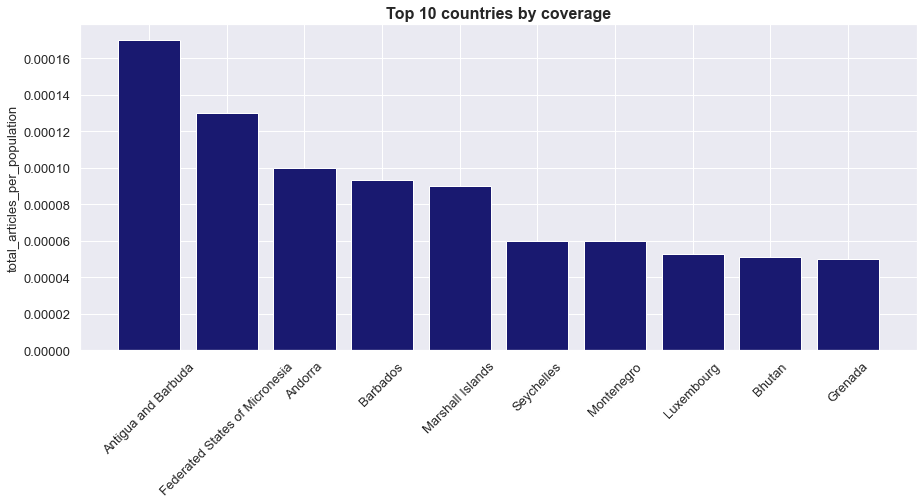

In [115]:
# A bar chart showing the top 10 countries by coverage
df_top_10_total_articles = df_top_10_total_articles.nlargest(10, 'total_articles_per_population')
plt.figure(figsize = (15,6)) #increate figure size
plt.bar(x = df_top_10_total_articles["country"], height = df_top_10_total_articles["total_articles_per_population"], color= "midnightblue" )
plt.xticks(rotation = 45, fontsize =13) #rotate x-axis labels at an angle of 45 degrees
plt.yticks(fontsize = 13)
plt.title("Top 10 countries by coverage", fontsize=16, fontweight="bold")
plt.ylabel("total_articles_per_population", fontsize=13)
plt.show()

- Bottom 10 countries by coverage: The 10 countries with the lowest total articles per capita (in ascending order) .


In [116]:
df_buttom_10_total_articles = df_country_final.copy()
df_buttom_10_total_articles.nsmallest(10, 'total_articles_per_population')

,region,country,population (millions),article_count,total_articles_per_population,quality_count,high_quality_per_person
43,EAST ASIA,China,1436.6,2,1.392176e-09,0.0,0.000000e+00
18,CENTRAL AMERICA,Mexico,127.5,1,7.843137e-09,0.0,0.000000e+00
170,WESTERN ASIA,Saudi Arabia,36.7,3,8.174387e-08,2.0,5.449591e-08
55,EASTERN EUROPE,Romania,19.0,2,1.052632e-07,2.0,1.052632e-07
107,SOUTH ASIA,India,1417.2,178,1.255998e-07,6.0,4.233700e-09
112,SOUTH ASIA,Sri Lanka,22.4,3,1.339286e-07,0.0,0.000000e+00
68,NORTHERN AFRICA,Egypt,103.5,14,1.352657e-07,0.0,0.000000e+00
30,EAST AFRICA,Ethiopia,123.4,25,2.025932e-07,3.0,2.431118e-08
48,EAST ASIA,Taiwan,23.2,5,2.155172e-07,0.0,0.000000e+00
121,SOUTHEAST ASIA,Vietnam,99.4,27,2.716298e-07,2.0,2.012072e-08


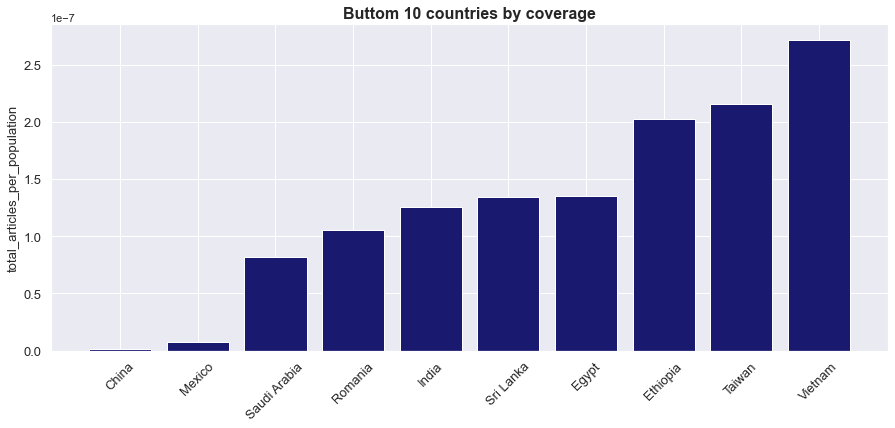

In [117]:
# A bar chart showing the buttom 10 countries by coverage
df_buttom_10_total_articles = df_buttom_10_total_articles.nsmallest(10, 'total_articles_per_population')
plt.figure(figsize = (15,6)) #increate figure size
plt.bar(x = df_buttom_10_total_articles["country"], height = df_buttom_10_total_articles["total_articles_per_population"], color= "midnightblue" )
plt.xticks(rotation = 45, fontsize =13) #rotate x-axis labels at an angle of 45 degrees
plt.yticks(fontsize = 13)
plt.title("Buttom 10 countries by coverage", fontsize=16, fontweight="bold")
plt.ylabel("total_articles_per_population", fontsize=13)
plt.show()

- Top 10 countries by high quality: The 10 countries with the highest high quality articles per capita (in descending order) .


In [119]:
df_top_10_total_quality = df_country_final.copy()
df_top_10_total_quality.nlargest(10, 'high_quality_per_person')

,region,country,population (millions),article_count,total_articles_per_population,quality_count,high_quality_per_person
90,OCEANIA,Tuvalu,0.0,11,inf,1.0,inf
127,SOUTHERN EUROPE,Andorra,0.1,10,0.000100,2.0,2.000000e-05
134,SOUTHERN EUROPE,Montenegro,0.6,36,0.000060,3.0,5.000000e-06
126,SOUTHERN EUROPE,Albania,2.8,83,0.000030,6.0,2.142857e-06
101,SOUTH AMERICA,Suriname,0.6,23,0.000038,1.0,1.666667e-06
128,SOUTHERN EUROPE,Bosnia-Herzegovina,3.4,52,0.000015,5.0,1.470588e-06
78,NORTHERN EUROPE,Lithuania,2.8,75,0.000027,3.0,1.071429e-06
129,SOUTHERN EUROPE,Croatia,3.8,54,0.000014,4.0,1.052632e-06
139,SOUTHERN EUROPE,Slovenia,2.1,43,0.000020,2.0,9.523810e-07
168,WESTERN ASIA,Palestinian Territory,5.4,71,0.000013,5.0,9.259259e-07


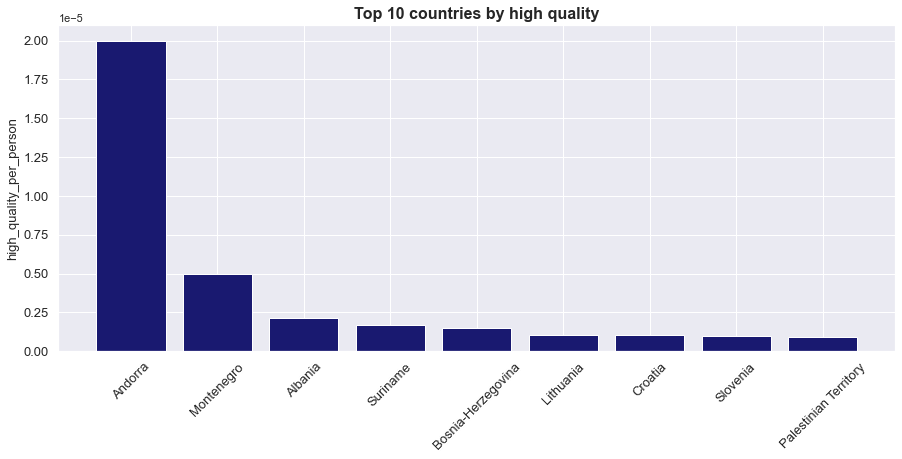

In [120]:
# A bar chart showing the top 10 countries by high quality coverage
df_top_10_total_quality = df_top_10_total_quality.nlargest(10, 'high_quality_per_person')
plt.figure(figsize = (15,6)) #increate figure size
plt.bar(x = df_top_10_total_quality["country"], height = df_top_10_total_quality["high_quality_per_person"], color= "midnightblue" )
plt.xticks(rotation = 45, fontsize =13) #rotate x-axis labels at an angle of 45 degrees
plt.yticks(fontsize = 13)
plt.title("Top 10 countries by high quality", fontsize=16, fontweight="bold")
plt.ylabel("high_quality_per_person", fontsize=13)
plt.show()

- Bottom 10 countries by high quality: The 10 countries with the lowest high quality articles per capita (in ascending order).


In [122]:
df_buttom_10_total_quality = df_country_final.copy()
df_buttom_10_total_quality.replace([0.0], np.nan, inplace=True)
# Drop rows with NaN
df_buttom_10_total_quality.dropna(inplace=True)
df_buttom_10_total_quality.nsmallest(10, 'high_quality_per_person')

,region,country,population (millions),article_count,total_articles_per_population,quality_count,high_quality_per_person
107,SOUTH ASIA,India,1417.2,178,1.255998e-07,6.0,4.233700e-09
119,SOUTHEAST ASIA,Thailand,66.8,28,4.191617e-07,1.0,1.497006e-08
44,EAST ASIA,Japan,124.9,108,8.646918e-07,2.0,1.601281e-08
153,WESTERN AFRICA,Nigeria,218.5,221,1.011442e-06,4.0,1.830664e-08
121,SOUTHEAST ASIA,Vietnam,99.4,27,2.716298e-07,2.0,2.012072e-08
96,SOUTH AMERICA,Colombia,49.1,58,1.181263e-06,1.0,2.036660e-08
40,EAST AFRICA,Uganda,47.2,44,9.322034e-07,1.0,2.118644e-08
111,SOUTH ASIA,Pakistan,235.8,120,5.089059e-07,5.0,2.120441e-08
71,NORTHERN AFRICA,Sudan,46.9,33,7.036247e-07,1.0,2.132196e-08
108,SOUTH ASIA,Iran,88.6,60,6.772009e-07,2.0,2.257336e-08


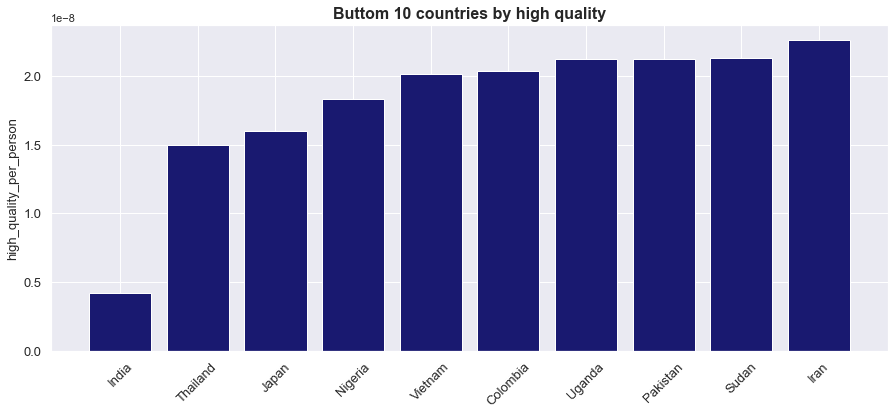

In [123]:
# A bar chart showing the buttom 10 countries by high quality coverage
df_buttom_10_total_quality = df_buttom_10_total_quality.nsmallest(10, 'high_quality_per_person')
plt.figure(figsize = (15,6)) #increate figure size
plt.bar(x = df_buttom_10_total_quality["country"], height = df_buttom_10_total_quality["high_quality_per_person"], color= "midnightblue" )
plt.xticks(rotation = 45, fontsize =13) #rotate x-axis labels at an angle of 45 degrees
plt.yticks(fontsize = 13)
plt.title("Buttom 10 countries by high quality", fontsize=16, fontweight="bold")
plt.ylabel("high_quality_per_person", fontsize=13)
plt.show()

In [124]:
df_by_region = df_country_final.groupby(by=['region'])\
                        .agg({'article_count':'sum', 'population (millions)':'sum', 'quality_count':'sum'}).reset_index()

In [125]:
df_by_region['total_articles_per_population'] = df_by_region['article_count']/(df_by_region['population (millions)'] * 1000000)

In [126]:
df_by_region['high_quality_per_person'] = df_by_region['quality_count']/(df_by_region['population (millions)'] * 1000000)

- Geographic regions by total coverage: A rank ordered list of geographic regions (in descending order) by total articles per capita.

In [127]:
df_region_by_coverage = df_by_region.copy()
df_region_by_coverage.nlargest(18, 'total_articles_per_population')

,region,article_count,population (millions),quality_count,total_articles_per_population,high_quality_per_person
8,NORTHERN EUROPE,262,33.8,8.0,7.751479e-06,2.366864e-07
9,OCEANIA,86,11.7,2.0,7.350427e-06,1.709402e-07
14,SOUTHERN EUROPE,890,150.9,46.0,5.897946e-06,3.048376e-07
0,CARIBBEAN,201,39.5,8.0,5.088608e-06,2.025316e-07
17,WESTERN EUROPE,699,196.9,22.0,3.550025e-06,1.117318e-07
5,EASTERN EUROPE,736,287.4,39.0,2.560891e-06,1.356994e-07
16,WESTERN ASIA,686,294.3,28.0,2.330955e-06,9.514101e-08
13,SOUTHERN AFRICA,117,68.1,4.0,1.718062e-06,5.873715e-08
3,EAST AFRICA,650,470.3,15.0,1.382097e-06,3.189454e-08
2,CENTRAL ASIA,106,78.0,3.0,1.358974e-06,3.846154e-08


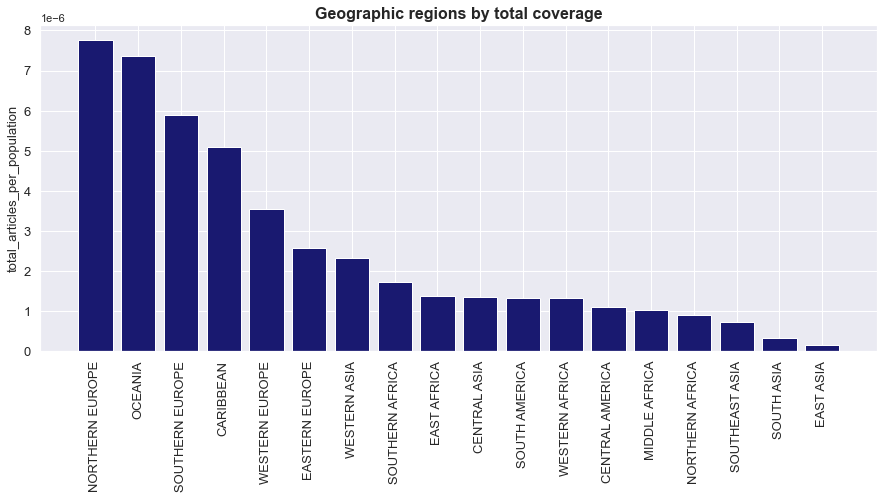

In [129]:
# A bar chart showing Geographic regions by total coverage
df_region_by_coverage =df_region_by_coverage.nlargest(18, 'total_articles_per_population')
plt.figure(figsize = (15,6)) #increate figure size
plt.bar(x = df_region_by_coverage["region"], height = df_region_by_coverage["total_articles_per_population"], color= "midnightblue" )
plt.xticks(rotation = 90, fontsize =13) #rotate x-axis labels at an angle of 45 degrees
plt.yticks(fontsize = 13)
plt.title("Geographic regions by total coverage", fontsize=16, fontweight="bold")
plt.ylabel("total_articles_per_population", fontsize=13)
plt.show()

- Geographic regions by high quality coverage: Rank ordered list of geographic regions (in descending order) by high quality articles per capita.


In [131]:
df_region_by_quality = df_by_region.copy()
df_region_by_quality.nlargest(18, 'high_quality_per_person')

,region,article_count,population (millions),quality_count,total_articles_per_population,high_quality_per_person
14,SOUTHERN EUROPE,890,150.9,46.0,5.897946e-06,3.048376e-07
8,NORTHERN EUROPE,262,33.8,8.0,7.751479e-06,2.366864e-07
0,CARIBBEAN,201,39.5,8.0,5.088608e-06,2.025316e-07
9,OCEANIA,86,11.7,2.0,7.350427e-06,1.709402e-07
5,EASTERN EUROPE,736,287.4,39.0,2.560891e-06,1.356994e-07
17,WESTERN EUROPE,699,196.9,22.0,3.550025e-06,1.117318e-07
16,WESTERN ASIA,686,294.3,28.0,2.330955e-06,9.514101e-08
13,SOUTHERN AFRICA,117,68.1,4.0,1.718062e-06,5.873715e-08
1,CENTRAL AMERICA,195,177.9,10.0,1.096121e-06,5.621135e-08
12,SOUTHEAST ASIA,412,559.7,24.0,7.361086e-07,4.288011e-08


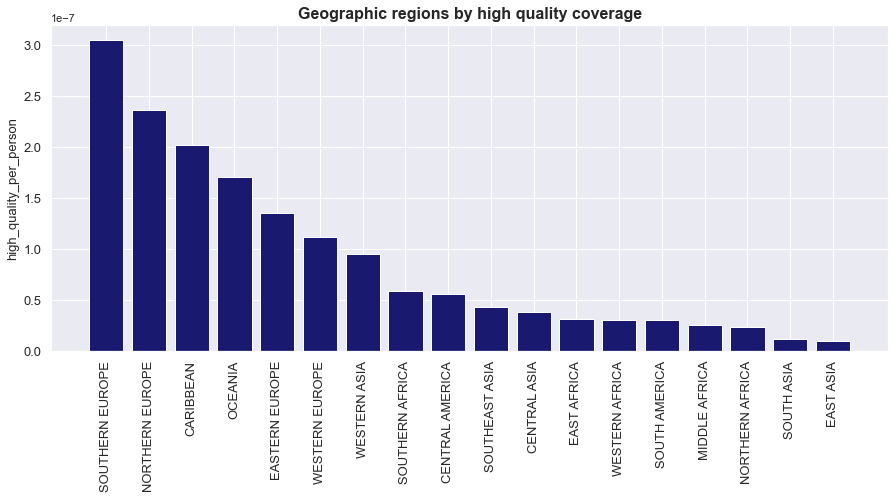

In [132]:
# A bar chart showing the Geographic regions by high quality coverage
df_region_by_quality =df_region_by_quality.nlargest(18, 'high_quality_per_person')
plt.figure(figsize = (15,6)) #increate figure size
plt.bar(x = df_region_by_quality["region"], height = df_region_by_quality["high_quality_per_person"], color= "midnightblue" )
plt.xticks(rotation = 90, fontsize =13) #rotate x-axis labels at an angle of 45 degrees
plt.yticks(fontsize = 13)
plt.title("Geographic regions by high quality coverage", fontsize=16, fontweight="bold")
plt.ylabel("high_quality_per_person", fontsize=13)
plt.show()

## Step 6: Write-up, Reflections and Implications


## Research Implications

### What I Learned

- Documentation and Reproducibility Are Hard<br/>
I often find myself complaining about how most open-source projects that I use (or try to) have scarce levels of documentation, and that they are hardly understandable, let alone reproducible. I now realize how hard it is to provide just enough information for someone else to have all the context that I have in order to replicate my work. When I put on my "new person to this repo" hat, I find my own work rife with holes and gaps. It is commendable that projects that are more complex by several orders of magnitude are adopted so heavily, and that the community drives the quality of the repository.

- Accuracy is not the End Goal<br/>
For the short period of four years that I have been dabbling in machine learning, I have always considered a numeric metric to be the goal; 99% is _always_ better than 95%. This assignment has taught me that critically analyzing the algorithm at hand, investigating the sources of bias, and providing context to the results are equally, if not more, important. I relate back to the phrase "the numbers speak for themselves", and think to myself "Well I can change that."

- What I Suspected (and Validated)

1. An obvious but important thing to note is that the source of these data is from the *English* Wikipedia pages. One might already suspect a bias in article quality due to this; articles about local politicians might be far richer in pages in their native language, than in English. Alternatively, if certain languages are not supported by Wikipedia, then pages relating to those countries, regardless of category, can be expected to be poorer in quality.
2. With the metric that we are trying to measure, the population might be a stronger factor than the number of articles for that country. The number of articles vary from 1 to a few thousand (max-min ratio of 10<sup>3</sup>), whereas the population varies from 10<sup>4</sup> to 10<sup>9</sup> (max-min ratio of 10<sup>5</sup>). This, in my opinion, is a biased metric to measure; a country with twice the population does not necessarily have twice the number of politicians, let alone pages about them.

### What I Found

1. As suspected, the highest ranked countries for the total number of articles per population overlap strongly with the least populated countries (8 out of 10 in the former are in the latter).
2. From the ORES Wiki:
 > The wp10 model bases its predictions on __structural characteristics__ of the article. E.g. How many sections are there? Is there an infobox? How many references? And do the references use a {{cite}} template? The wp10 model __doesn't evaluate the quality of the writing__ or whether or not there's a tone problem (e.g. a point of view being pushed). However, many of the structural characteristics of articles __seem to correlate__ strongly with good writing and tone, so the models work very well in practice.

The way the ORES model evaluates the quality of the article itself appears to be biased towards the structure of the article than the content. In contrast, the original WP10 [article assessment](https://en.wikipedia.org/wiki/Wikipedia:Content_assessment#Grades) performed by humans has very strongly worded and thoughtful criteria to attain a certain quality level.